<a href="https://colab.research.google.com/github/Ranjithkrishnasamy/Resub-DS-24/blob/main/Decisiontrees(Fraudcheck).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
pip install imbalanced-learn

In [17]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [18]:
path = r"/content/Fraud_check.csv"

In [19]:
data = pd.read_csv(path)

In [20]:
data['Taxable_Income_Category'] = pd.cut(data['Taxable.Income'],
                                         bins=[0, 30000, float('inf')],
                                         labels=['Risky', 'Good'])

In [21]:
data.drop(columns=['Taxable.Income'], inplace=True)

In [22]:
label_encoder = LabelEncoder()
data['Undergrad'] = label_encoder.fit_transform(data['Undergrad'])
data['Marital.Status'] = label_encoder.fit_transform(data['Marital.Status'])
data['Urban'] = label_encoder.fit_transform(data['Urban'])

In [23]:
X = data.drop(['Taxable_Income_Category'], axis=1)
y = data['Taxable_Income_Category']

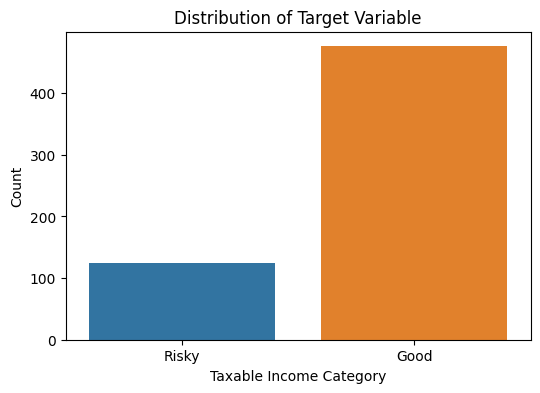

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Taxable_Income_Category', data=data)
plt.xlabel('Taxable Income Category')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

In [25]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

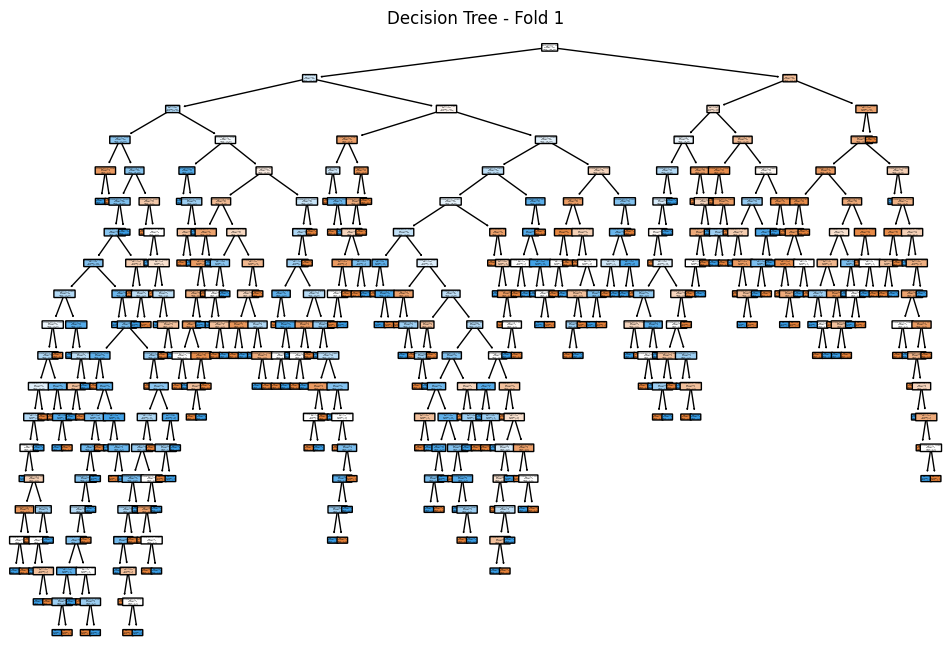

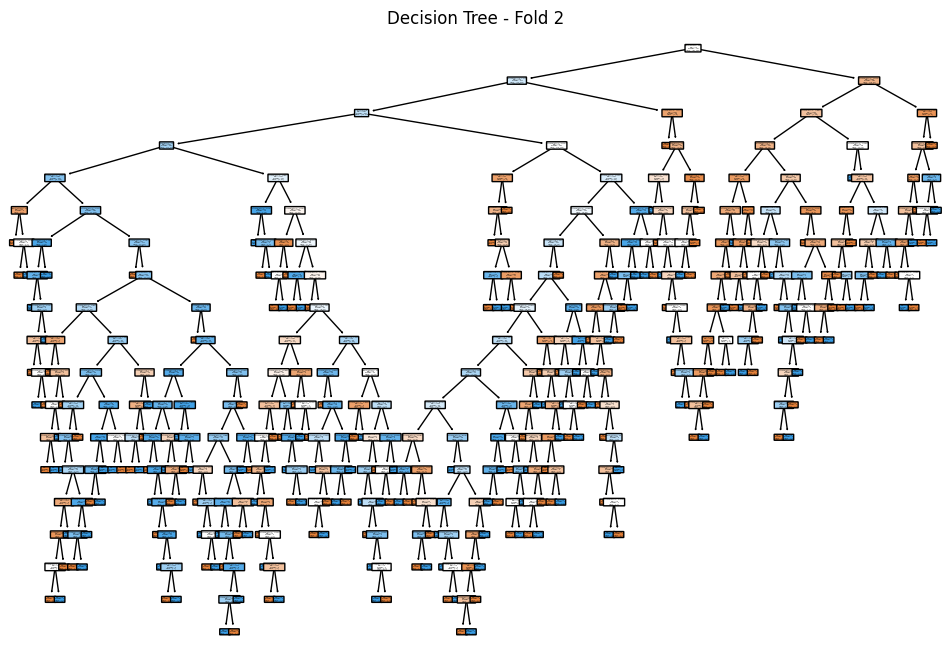

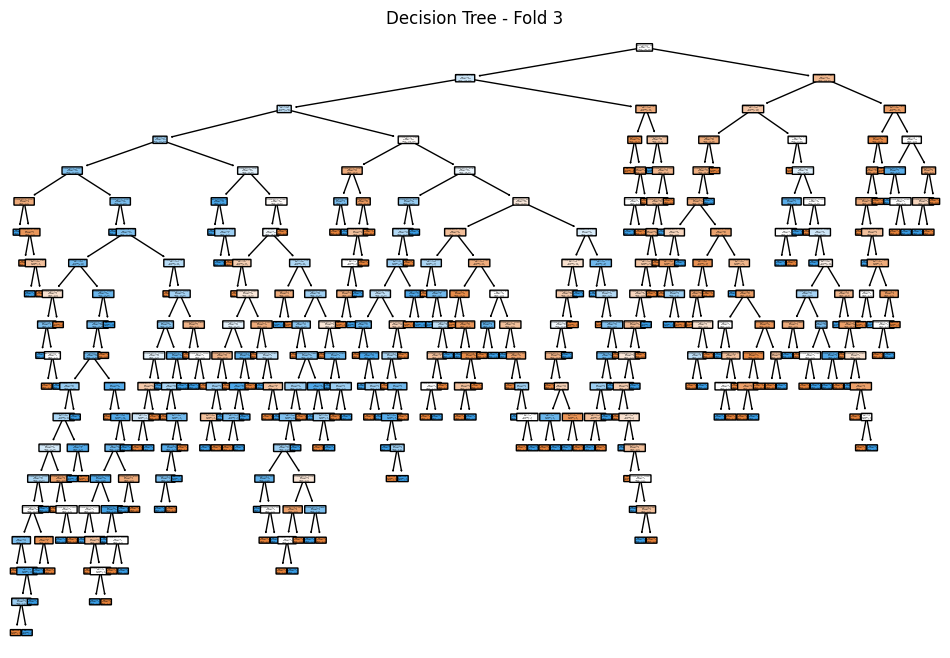

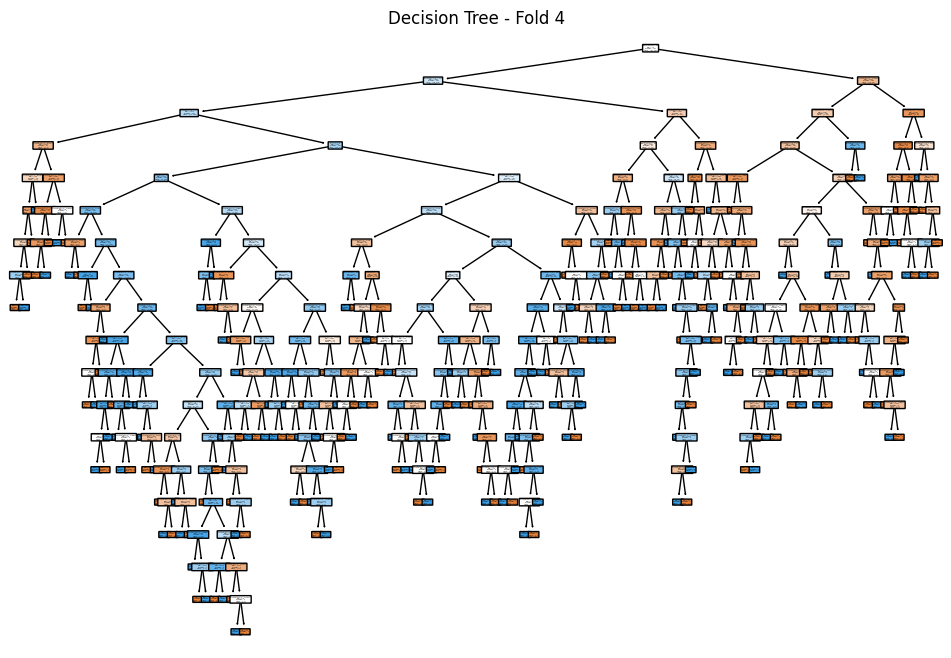

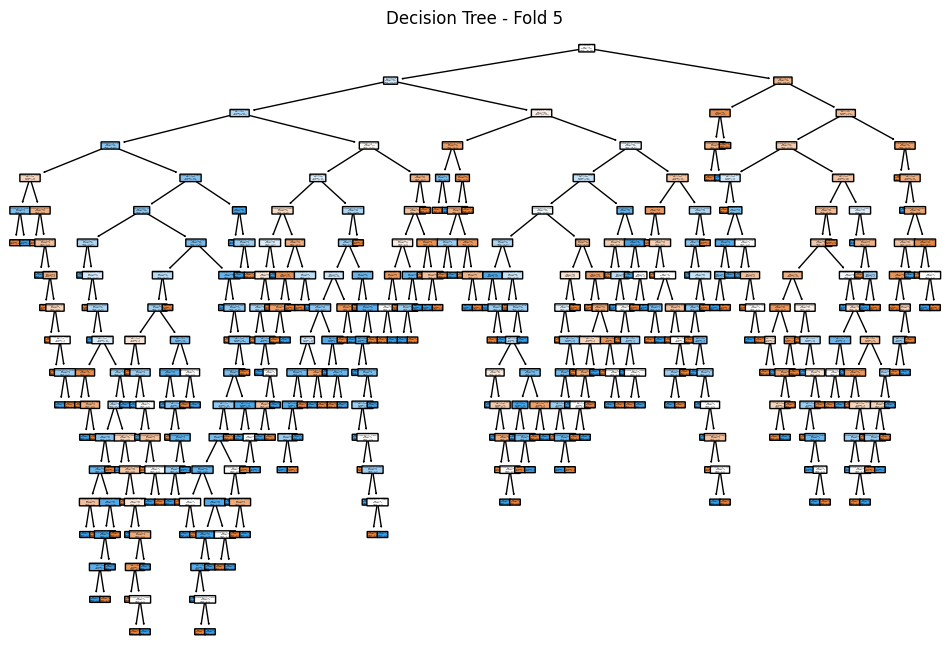

In [26]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X_resampled_smote, y_resampled_smote)):
    X_train, X_test = X_resampled_smote.iloc[train_index], X_resampled_smote.iloc[test_index]
    y_train, y_test = y_resampled_smote.iloc[train_index], y_resampled_smote.iloc[test_index]

    # Fit the decision tree classifier
    clf = DecisionTreeClassifier(criterion='gini', random_state=42)
    clf.fit(X_train, y_train)

    # Visualize the decision tree
    plt.figure(figsize=(12, 8))
    plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True)
    plt.title(f"Decision Tree - Fold {fold+1}")
    plt.show()

In [27]:
params = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7]}
grid_search = GridSearchCV(clf, params, cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7]})

In [28]:
pruned_clf = grid_search.best_estimator_

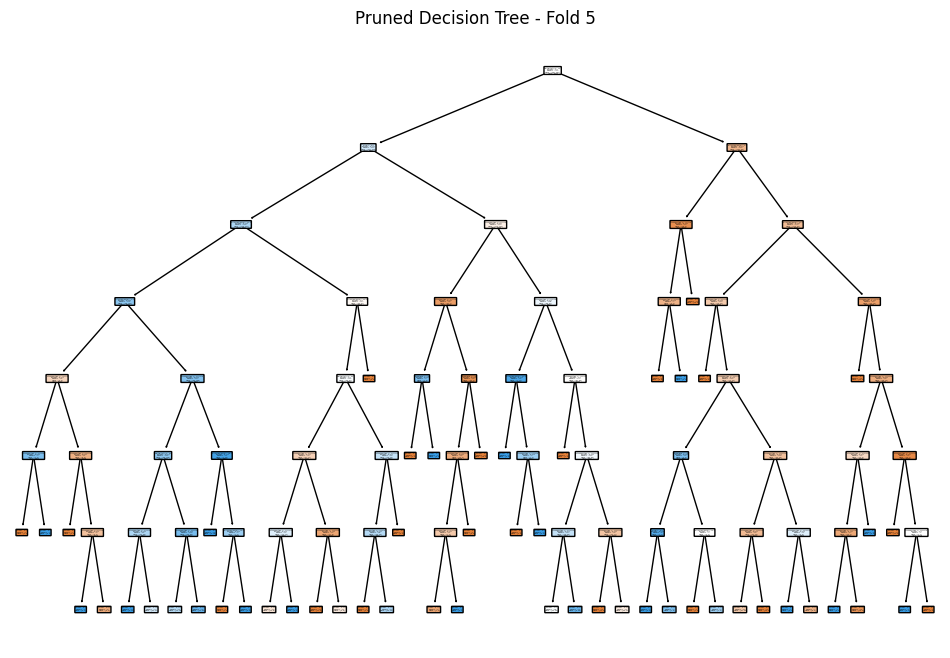

In [29]:
plt.figure(figsize=(12, 8))
plot_tree(pruned_clf, feature_names=X.columns, class_names=pruned_clf.classes_, filled=True, rounded=True)
plt.title(f"Pruned Decision Tree - Fold {fold+1}")
plt.show()

In [30]:
y_pred = pruned_clf.predict(X_test)

In [32]:
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

In [34]:
print(f"Fold {fold+1} - Accuracy:", accuracy)
print(f"Fold {fold+1} - Confusion Matrix:")
print(conf_mat)
print(f"Fold {fold+1} - Classification Report:")
print(classification_report(y_test, y_pred))

Fold 5 - Accuracy: 0.6263157894736842
Fold 5 - Confusion Matrix:
[[53 42]
 [29 66]]
Fold 5 - Classification Report:
              precision    recall  f1-score   support

        Good       0.65      0.56      0.60        95
       Risky       0.61      0.69      0.65        95

    accuracy                           0.63       190
   macro avg       0.63      0.63      0.62       190
weighted avg       0.63      0.63      0.62       190



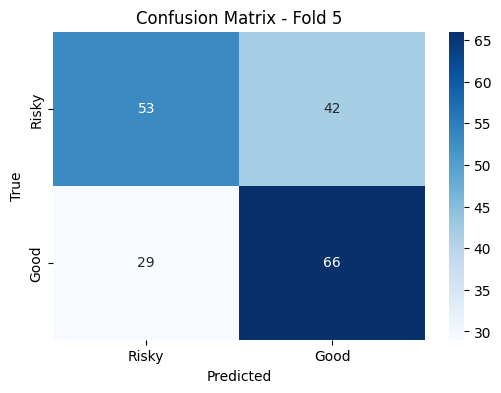

In [35]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Risky', 'Good'], yticklabels=['Risky', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Confusion Matrix - Fold {fold+1}")
plt.show()